## ChebPE


This jupyter notebook presents a modified version of the ChebAE algorithm from [arXiv:2207.08628](https://arxiv.org/abs/2207.08628). Say $a \in [0,1]$ is an amplitude. Given an oracle that for a parameter $k$ tosses a coin that comes up heads with probability
$$\sin^2( (2k+1) \arcsin(a) )  $$
at cost $k$, the objective is to estimate the probability $a^2$ with minimal cost. The ChebAE algorithm estimates the amplitude $a$. The ChebPE algorithm presented in this notebook modifies ChebAE to estimate the probability $p := a^2$ instead.

It was observed that $\sin^2( (2k+1) \arcsin(a) ) = T^2_n(a)$ where $n = 2k+1$, where $T_n$ is the $n$'th Chebyshev polynomial of the first kind. In this modified version we are hence interested in $T^2_n(\sqrt{p})$. Fortunately, this function behaves rather similarly to $T^2_n(a)$: the function oscillates as a function of $p$, and the slope of the oscillations, though varying with $p$, is roughly linear in $n$. This is the central assumption that goes into the design of the 'early-late' condition. In ChebPE, we are 'late' whenever the following holds:
$$ \varepsilon_\text{max}^{T^2} \cdot \frac{p_\text{max} - p_\text{min}}{|T^2_n(\sqrt{p_\text{max}}) - T^2_n(\sqrt{p_\text{min}})|} \leq \nu \varepsilon$$
where $[p_\text{min},p_\text{max}]$ is the current confidence interval on $p$, $\varepsilon$ is the desired final accuracy, $\nu$ is a hyperparameter, and $\varepsilon_\text{max}^{T^2}$ is the largest possible error in our estimate of $T^2(\sqrt{p})$ using $N_\text{shots}$ many shots. Once the late condition holds then $N_{shots}$ might be significantly more shots than necessary to get the desired accuracy, so it makes sense to take the shots one at a time rather than in bunches of $N_\text{shots}$. The parameter $\nu$ governs how 'cautiously' we trigger this condition. Optimizing $\nu$ was the primary source of the speedup in ChebAE.



In [1]:
import numpy as np
from scipy.special import eval_chebyt as cheb
from scipy.stats import binom
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt
import json, os

# Subroutines

In [2]:

def invert_T2rootp(T2,n,p_int):
    """ Given T2, find a p such that T2 = T^2_n( sqrt(p) ). There may be multiple solutions so select the closest one to p_int. """
    
    # Just map to the invert function from ChebAE.
    # See that function's implementation for detailed comments.
    theta_int = np.arccos(np.sqrt(p_int))
    c = np.pi/(2*n)
    t = np.floor(theta_int/c)
    
    if t % 2 == 0: theta = np.arccos(2*T2-1)/(2*n)
    else: theta = 2*c - np.arccos(2*T2-1)/(2*n)

    k = t//2
    theta += np.pi*k/n
    return np.cos(theta)**2


def find_next_k(p_min, p_max, min_k=0):
    """Find a k >= min_k such that when n = 2k+1 the function T^2_n(sqrt(p)) has no extrema on the interval [p_min, p_max]."""

    # Step 1: convert to theta.
    theta_lo = np.arccos(np.sqrt(p_max))
    theta_hi = np.arccos(np.sqrt(p_min))
    
    # Step 2: get highest possible degree.
    n = int((np.pi/2)/(theta_hi-theta_lo))
    if n % 2 == 0: n += 1 # make it odd

    # Step 3: search for the highest degree without any extrema.
    while n > 2*min_k+1:
        if int(2*n*theta_lo/np.pi) == int(2*n*theta_hi/np.pi):
            return (n-1)//2 # Done!
        n -= 2           
    return None # Couldn't find a degree > min_deg.


def max_error_cp(delta, Nshots):
    """ Say we tossed a coin with unknown bias Nshots many times, and we want a confidence interval with confidence >= 1-delta. What is the widest that this interval could be? Relies on Clopper-Pearson confidence interval method."""

    # Loop over all possible numbers of heads.
    max_error = 0
    for counts in range(0,Nshots+1):
        lower,upper = proportion_confint(counts, Nshots,
                                         method="beta",
                                         alpha=delta)
        if (upper-lower)/2 > max_error:
            max_error = (upper-lower)/2
    
    return max_error   


# Main Algorithm

In [3]:
def chebpe(p_target, eps, alpha,
           nu=8, r=2, Nshots=100):

    # Step 1: determine the total number of confidence intervals
    # and distribute failure probability budget evenly among them
    T = int(np.ceil(np.log(1/(2*eps))/np.log(r)))
    alpha_T = alpha/T 
    
    # Step 2: precompute cutoff parameters.
    err_max = max_error_cp(alpha_T, Nshots)
        
    # Step 3: Initialize
    p_min, p_max = 0, 1 # confidence interval
    num_flips, num_heads = 0, 0 # coin toss tally    
    k = 0 
    queries = 0 
    
    # Step 4:
    while p_max - p_min > eps*2:

        # Step 4(a)
        # Try to find a better polynomial with k > r*k.
        new_k = find_next_k(p_min, p_max, min_k=r*k)

        # Found a better polynomial? If so, reset the counts.
        if new_k is not None:
            k = new_k
            num_flips, num_heads = 0, 0
        
        # Step 4(b): determine 'late' or 'early' to avoid taking too many samples
        # by setting N_shots_i - the number of shots in this iteration
        gap = cheb(2*k+1, np.sqrt(p_max))**2 - cheb(2*k+1, np.sqrt(p_min))**2
        if err_max * (p_max - p_min)/gap < nu*eps:
            Nshots_i = 1      # late: sample one-at-a-time
        else:
            Nshots_i = Nshots # early: take lots of samples

        # Step 4(c): Simulate the quantum computer to toss coins
        T2 = cheb(2*k+1, np.sqrt(p_target))**2
        for i in range(Nshots_i):
            if np.random.random() < T2: num_heads += 1
            num_flips += 1
            # queries += k
            queries += 2*k+1

        # Step 4(d): determine confidence interval for prob
        T2_min, T2_max = proportion_confint(num_heads, num_flips,
                                            method="beta",
                                            alpha=alpha_T)
        
        # Step 4(e): back-propagate [p_min,p_max] to confidence
        # interval for [p_min_star, p_max_star] for p_true
        p_int = np.mean([p_min,p_max])
        p_min_star = invert_T2rootp(T2_min,2*k+1,p_int)
        p_max_star = invert_T2rootp(T2_max,2*k+1,p_int)
        p_min_star, p_max_star = sorted([p_min_star, p_max_star])

        # prevent floating point glitches
        p_min_star -= 1e-15
        p_max_star += 1e-15

        # Step 5(d): update the interval
        p_min, p_max = max(p_min, p_min_star), min(p_max, p_max_star)
      
    return {'algorithm':"ChebPE",
            'config': {'nu':nu, 'r':r, 'Nshots':Nshots},
            'epsilon': eps, 
            'p_target': p_target,
            'alpha': alpha,
            'p_estimate': np.mean([p_min,p_max]),
            'exact_error': abs(p_target-np.mean([p_min,p_max])),
            'ci_width': (p_max - p_min)/2,
            'num_oracle_calls': queries}

# Data Collection

In [4]:
from tqdm import tqdm

100%|██████████| 10000/10000 [07:18<00:00, 22.79it/s]

[0.7442 0.6906 0.6455 0.5979 0.5547 0.518  0.4814 0.4463 0.4149 0.3841
 0.3569 0.3291 0.3046 0.2808 0.2582 0.239  0.2197 0.2021 0.1852 0.1711
 0.1567]


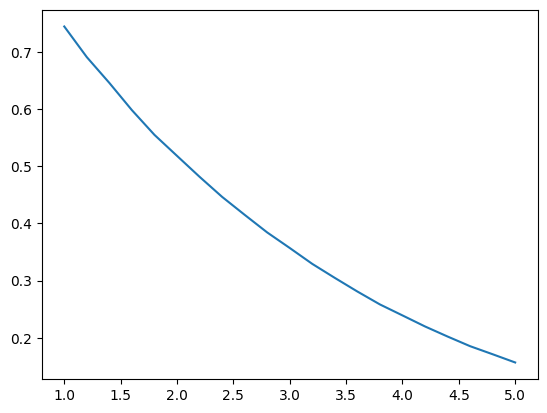

In [5]:
src = np.random.random(10000)
res = [chebpe(p,0.02,0.05) for p in tqdm(src)]
Ns = np.array([r['num_oracle_calls'] for r in res])
est = np.array([r['p_estimate'] for r in res])
Neps = Ns * np.abs(est - src)
deltas = np.array([len(Neps[Neps > delta])/len(Neps) for delta in np.arange(1,5.01,0.2)])
print(deltas)
plt.plot(np.arange(1,5.01,0.2),deltas)

In [6]:
np.savetxt('chebpe.txt',deltas, fmt='%.4f', delimiter=',')